This notebook contains helper functions for the evaluation of the algorithms;<br> <br>



*   multi-test : run the algorithm on the data set k times with a test-train-split of 33%, returns a data frame with the scores of the tests
*   k_folds_tests: run the algorithm on the data set k times with k-folds cross-validation (randomly shuffle before creating the folds) and returns a data frame with the scores of the tests 


In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 2.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894088 sha256=5c9d598434481be563b3dce6e514d29e01baee26e8da75f7a7dfc9f9d00f45ad
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
from time import time
from sklearn.model_selection import KFold

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve, auc, accuracy_score,f1_score,average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Function taking Algo and Dataset and returns Scores and Preds : scores_preds(algorithm, X_train, X_test)


In [ ]:
def scores_preds(algorithm, X_train, X_test):
  # Randomly split X!
  t0 = time()
  algorithm.fit(X_train);
  tTrain = time() - t0;

  t0 = time();
  scores = algorithm.score_samples(X_test);
  tTest = time() - t0;

  preds = algorithm.predict(X_test)

  return (scores, preds, tTrain, tTest)


##Printing results

In [ ]:
def get_scores(label,scores,preds,y, tTrain = 0, tTest = 0):
  comparison_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  comparaison_data = pd.DataFrame(columns=comparison_columns)

  comparaison_data.loc[label] = [accuracy_score(y,preds), f1_score(y,preds), roc_auc_score(y,scores),average_precision_score(y,scores, average='weighted'), tTrain, tTest]

  return comparaison_data

##Test Cases

###Mulcross

In [ ]:
iforest = IsolationForest()

mulcrossData = pd.read_csv("mulcross.csv")
mulcrossData.Target = mulcrossData.Target.map(lambda target: 0 if (target == "'Normal'" or target == 0) else 1)
mulcrossData["Class"] = mulcrossData.Target
mulcrossData = mulcrossData.drop(["Target"], axis = 1)

mulcrossX = mulcrossData.drop(["Class"], axis = 1)
mulcrossY = mulcrossData.Class

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mulcrossX, mulcrossY)

In [ ]:
scores, preds, tTrain, tTest = scores_preds(iforest, X_train, X_test)
preds = preds == -1
scores = - scores

In [ ]:
scores.max()

0.6992303852250978

In [ ]:
get_scores("sklearn - mulcross", scores,preds, y_test,tTrain, tTest).head()

,Accuracy,F1,AUC ROC,AUC PR,Train Time,Testing Time
sklearn - mulcross,0.872589,0.611808,0.950436,0.481662,1.173095,2.449021


#Function Taking Algo, Dataset splits, does K iterations and returns dataframe of ran tests, which we can use to get means

## multi_tests(algorithm, X, y, repetition = 10, preds_negatif = False, scores_negatif = False):

In [ ]:
#Score negatif is used because sci kit returns -1 for anomalies and 1 for normal points, so we put it to True for sci-kit 
def multi_tests(algorithm, X, y, repetition = 10, preds_negatif = False, scores_negatif = False):
  eval_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  eval_data = pd.DataFrame(columns=eval_columns)

  for i in range(0,repetition):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    scores, preds, tTrain, tTest = scores_preds(iforest, X_train, X_test)

    if(preds_negatif):
      preds = preds == -1

    if(scores_negatif):
      scores = - scores

    eval_data.loc[f"test {i}"] = get_scores("sklearn - mulcross", scores,preds, y_test,tTrain, tTest).iloc[0]


  return eval_data

  

##Test Cases

In [ ]:
iforest = IsolationForest()

mulcrossData = pd.read_csv("mulcross.csv")
mulcrossData.Target = mulcrossData.Target.map(lambda target: 0 if (target == "'Normal'" or target == 0) else 1)
mulcrossData["Class"] = mulcrossData.Target
mulcrossData = mulcrossData.drop(["Target"], axis = 1)

mulcrossX = mulcrossData.drop(["Class"], axis = 1)
mulcrossY = mulcrossData.Class

In [ ]:
tests = multi_tests(iforest, mulcrossX, mulcrossY,repetition = 50,preds_negatif = True, scores_negatif = True)

In [ ]:
tests.mean()

Accuracy        0.870563
F1              0.607926
AUC ROC         0.958365
AUC PR          0.536294
Train Time      1.037699
Testing Time    2.349862
dtype: float64

#Function Taking Algo, Dataset splits, and does k-folds

## k_folds_tests(algorithm, X, y, folds = 10, preds_negatif = False, scores_negatif = False)

In [ ]:
def k_folds_tests(algorithm, X, y, folds = 10, preds_negatif = False, scores_negatif = False, force_numpy = False):

  eval_columns = ["Accuracy", "F1", "AUC ROC","AUC PR", "Train Time", "Testing Time"]
  eval_data = pd.DataFrame(columns=eval_columns)

  kf = KFold(n_splits= folds)

  i = 1

  for train_index, test_index in kf.split(X):

    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    if(force_numpy):
      X_train = X_train.to_numpy();
      X_test = X_test.to_numpy();

    scores, preds, tTrain, tTest = scores_preds(algorithm, X_train, X_test)

    if(preds_negatif):
      preds = preds == -1

    if(scores_negatif):
      scores = - scores

    eval_data.loc[f"test {i}"] = get_scores(" - ", scores,preds, y_test,tTrain, tTest).iloc[0]
    i+=1

  return eval_data

  

## Test Cases

In [ ]:
tests = k_folds_tests(iforest, mulcrossX, mulcrossY,preds_negatif = True, scores_negatif = True)

In [ ]:
tests.mean()

Accuracy        0.872925
F1              0.611763
AUC ROC         0.960478
AUC PR          0.548871
Train Time      1.146793
Testing Time    0.892633
dtype: float64

In [ ]:
# IMPORT FuzzyIForest to collab here !
from FuzzyIforest import AlphaCutIForestModel

In [ ]:
ifuzzyforest = AlphaCutIForestModel(number_of_trees = 100, sample_size = 256)

In [ ]:
tests = k_folds_tests(ifuzzyforest,mulcrossX, mulcrossY, folds = 4, force_numpy = True)

In [ ]:
tests.mean()

Accuracy         0.929840
F1               0.649167
AUC ROC          0.965397
AUC PR           0.585255
Train Time       1.151146
Testing Time    49.452094
dtype: float64

# Datasets Graphs and looks

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def pca_stuff(dataset):
  datasetY = dataset.Class
  datasetX = dataset.drop(['Class'],axis = 1) 
  features = dataset.columns

  # Separating out the features
  X = dataset.loc[:, features].values

  # Seperating out the target
  y = dataset.loc[:,['Class']].values

  # Standardizing the features
  X = StandardScaler().fit_transform(X)

  # Recombining the Data into one DataFrame
  standardizedData = pd.DataFrame(X, columns= features)
  standardizedData['Class'] = pd.DataFrame(y, columns=["Class"])

  # Instantiating PCA with number of components =  for 3D visualization
  pca = PCA(n_components = 3)

  # Apply PCA
  principalComponents = pca.fit_transform(standardizedData.loc[:,standardizedData.columns != 'Class'])

  # Create New DataFrame for resulting data
  principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1','PC2','PC3'])

  # Recombining with Target Column
  principalDf['Class'] = standardizedData.Class

  print(principalDf.head())

  # Split Anomalous and Normal points for visualization

  normalPoints = principalDf.loc[principalDf.Class == 0]

  anomalies = principalDf.loc[principalDf.Class == 1]
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection='3d')

  ax.scatter(normalPoints.PC1, normalPoints.PC2,normalPoints.PC3, c = "blue", label = "Normal Points", s = 100)
  ax.scatter(anomalies.PC1, anomalies.PC2,anomalies.PC3, c = "orange", label = "Anomalous Points", s = 100)
  ax.legend()     

In [ ]:
def clean_show(dataset):
  print(dataset.head())
  sns.countplot(x = 'Class', data = dataset)
  percent = dataset.value_counts('Class')[1] / len(dataset)
  print(f"% PERCENT OF DISPARITY = {percent}")
  print(f"Len = {len(dataset)}")
  pca_stuff(dataset)



## Mulcross

In [ ]:
mulcrossData = pd.read_csv("mulcross.csv")
mulcrossData['Class'] = mulcrossData.Target.map(lambda target: 0 if (target == "'Normal'" or target == 0) else 1)
mulcrossData = mulcrossData.drop(["Target"], axis = 1)

         V1        V2        V3        V4  Class
0 -0.203950  0.363011  1.013766  0.187131      0
1 -0.761118  2.436424  0.681846  0.654366      0
2 -0.209979  1.131098 -0.282180 -0.202210      0
3  0.836812  0.650342 -0.426900 -0.305281      0
4  0.454204  1.560128 -0.204841  0.219233      0
% PERCENT OF DISPARITY = 0.1015406162464986
Len = 35700
        PC1       PC2       PC3  Class
0 -0.553586 -0.479875  0.226174      0
1 -0.640491  0.382170  2.152845      0
2 -0.288805  0.459103  1.073025      0
3  0.244226 -0.282665  0.852739      0
4  0.182830 -0.043230  1.643975      0


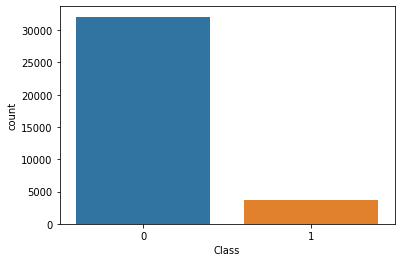

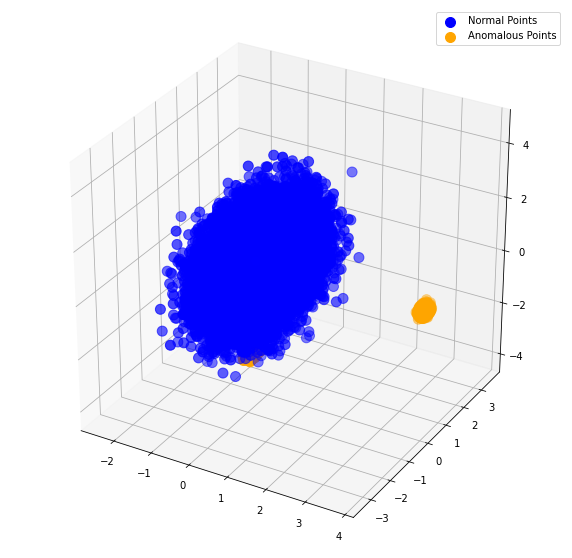

In [ ]:
clean_show(mulcrossData)

## Heart Disease

In [ ]:
# Loading the Heart Disease Dataset

from sklearn.preprocessing import LabelEncoder

healthcare = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Label Encoder for the Categorical Values
label_encoder = LabelEncoder()

# Encode Labels
healthcare.gender = label_encoder.fit_transform(healthcare.gender)
healthcare.ever_married = label_encoder.fit_transform(healthcare.ever_married)
healthcare.work_type = label_encoder.fit_transform(healthcare.work_type)
healthcare.smoking_status = label_encoder.fit_transform(healthcare.smoking_status)
healthcare.Residence_type = label_encoder.fit_transform(healthcare.Residence_type)

healthcare["Class"] = healthcare.stroke
healthcare = healthcare.drop(["stroke"], axis = 1)

# Drop Null Values
healthcare = healthcare.dropna()

      id  gender   age  ...   bmi  smoking_status  Class
0   9046       1  67.0  ...  36.6               1      1
2  31112       1  80.0  ...  32.5               2      1
3  60182       0  49.0  ...  34.4               3      1
4   1665       0  79.0  ...  24.0               2      1
5  56669       1  81.0  ...  29.0               1      1

[5 rows x 12 columns]
% PERCENT OF DISPARITY = 0.04257486249745366
Len = 4909
        PC1       PC2       PC3  Class
0  2.463235  3.796217  0.137756      1
1  2.247590  2.470461  0.286557      1
2  1.553755 -0.584753 -1.268448      1
3  1.893457  1.634157  2.344790      1
4  1.439475  1.161452 -1.420045      1


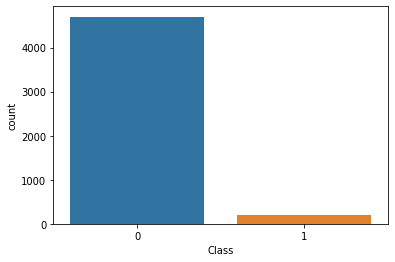

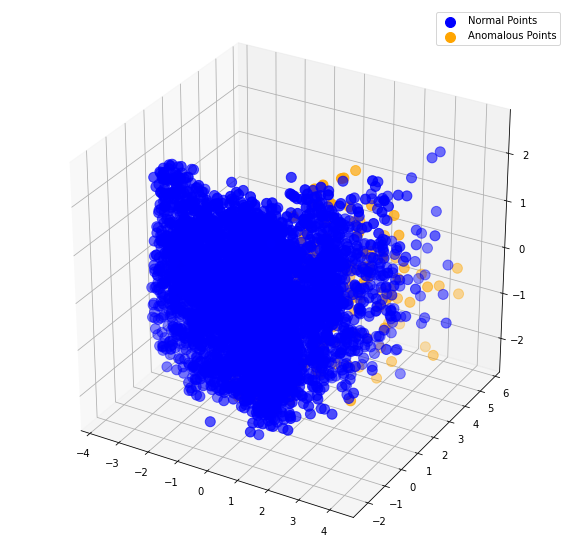

In [ ]:
clean_show(healthcare)

## Breast Cancer

In [ ]:
breast_cancer = pd.read_csv("breast cancer.csv")

# Label Encoder for the Categorical Values
label_encoder = LabelEncoder()

breast_cancer.diagnosis = label_encoder.fit_transform(breast_cancer.diagnosis)

breast_cancer["Class"] = breast_cancer.diagnosis
breast_cancer = breast_cancer.drop(["diagnosis"], axis = 1)

         id  radius_mean  ...  fractal_dimension_worst  Class
0    842302        17.99  ...                  0.11890      1
1    842517        20.57  ...                  0.08902      1
2  84300903        19.69  ...                  0.08758      1
3  84348301        11.42  ...                  0.17300      1
4  84358402        20.29  ...                  0.07678      1

[5 rows x 32 columns]
% PERCENT OF DISPARITY = 0.37258347978910367
Len = 569
        PC1        PC2       PC3  Class
0  9.183200   1.971271 -1.171625      1
1  2.383298  -3.753459 -0.580229      1
2  5.742472  -1.080350 -0.533088      1
3  7.124384  10.272225 -3.150161      1
4  3.945694  -1.959689  1.401177      1


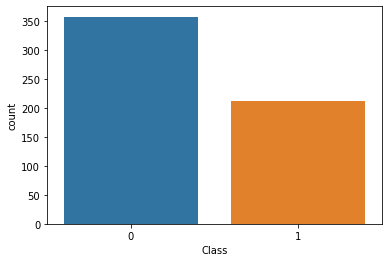

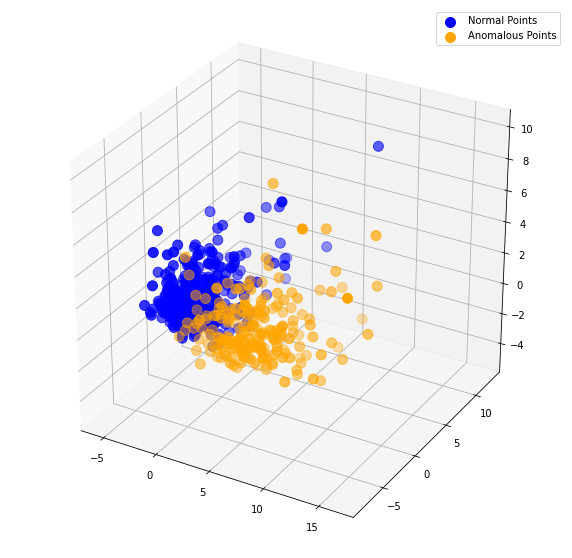

In [ ]:
clean_show(breast_cancer)

## Diabetes

In [ ]:
diabetes = pd.read_csv("diabetes.csv")
diabetes["Class"] = diabetes.Outcome
diabetes = diabetes.drop(["Outcome"], axis = 1)

   Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Class
0            6      148             72  ...                     0.627   50      1
1            1       85             66  ...                     0.351   31      0
2            8      183             64  ...                     0.672   32      1
3            1       89             66  ...                     0.167   21      0
4            0      137             40  ...                     2.288   33      1

[5 rows x 9 columns]
% PERCENT OF DISPARITY = 0.3489583333333333
Len = 768
        PC1       PC2       PC3  Class
0  1.068503  1.234895  0.095930      1
1 -1.121683 -0.733852 -0.712938      0
2 -0.396477  1.595876  1.760678      1
3 -1.115781 -1.271241 -0.663729      0
4  2.359334 -2.184819  2.963107      1


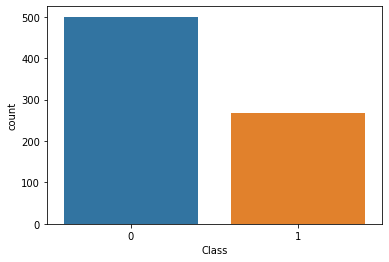

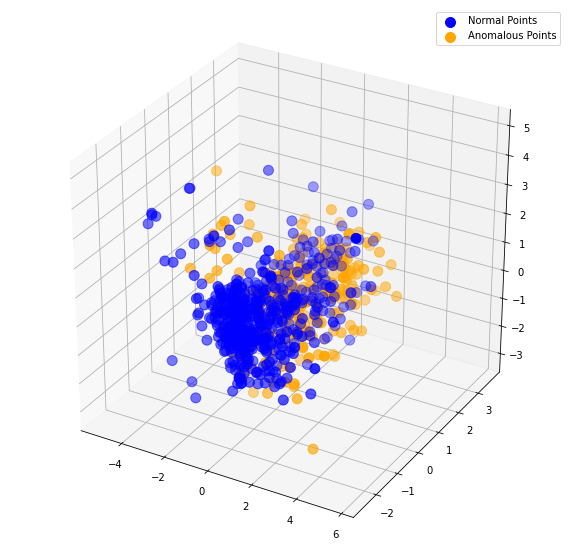

In [ ]:
clean_show(diabetes)

## Credit Cards

In [ ]:
# Loading the Credit Cards Dataset
credit_cards = pd.read_csv("creditcard.csv")
credit_cards = credit_cards.dropna()

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62    0.0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69    0.0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66    0.0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50    0.0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99    0.0

[5 rows x 31 columns]
% PERCENT OF DISPARITY = 0.0019072392590399744
Len = 206057
        PC1       PC2       PC3  Class
0  0.252204  2.146676 -0.097290    0.0
1 -0.473447  2.047348 -0.186917    0.0
2  1.669288  2.335919  0.511608    0.0
3  0.182101  1.545391 -0.666065    0.0
4 -0.125267  1.481612  0.124833    0.0


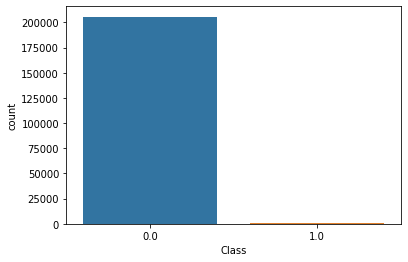

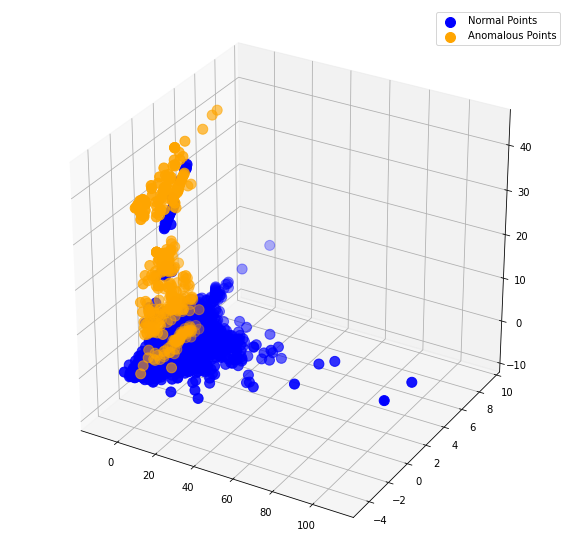

In [ ]:
clean_show(credit_cards)